# Makemore

A character-level language model that is learnt in an auto-regressive fashion.    
The model is a simple bigram model implemented using a bigram matrix, as well as using a single neuron.

In [1]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

CHARS = 27
SEED = 2147483647

#### Get data.

In [2]:
words = open('./data/names.txt', 'r').read().splitlines()

print(f"Number of words: {len(words)}")
print(f"First 10 words: {words[:10]}")
print(f"Min word length: {min(len(w) for w in words)}")
print(f"Max word length: {max(len(w) for w in words)}")

Number of words: 32033
First 10 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Min word length: 2
Max word length: 15


#### Construct bigrams.

In [3]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [4]:
TOPK = 10
sorted(b.items(), key = lambda kv: -kv[1])[:TOPK]


[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

#### Visualize the bigram matrix.

[This is boilerplate code. It was not written from scratch.    
Sometimes `Ctrl+C` and `Ctrl+V` are useful shortcuts.]

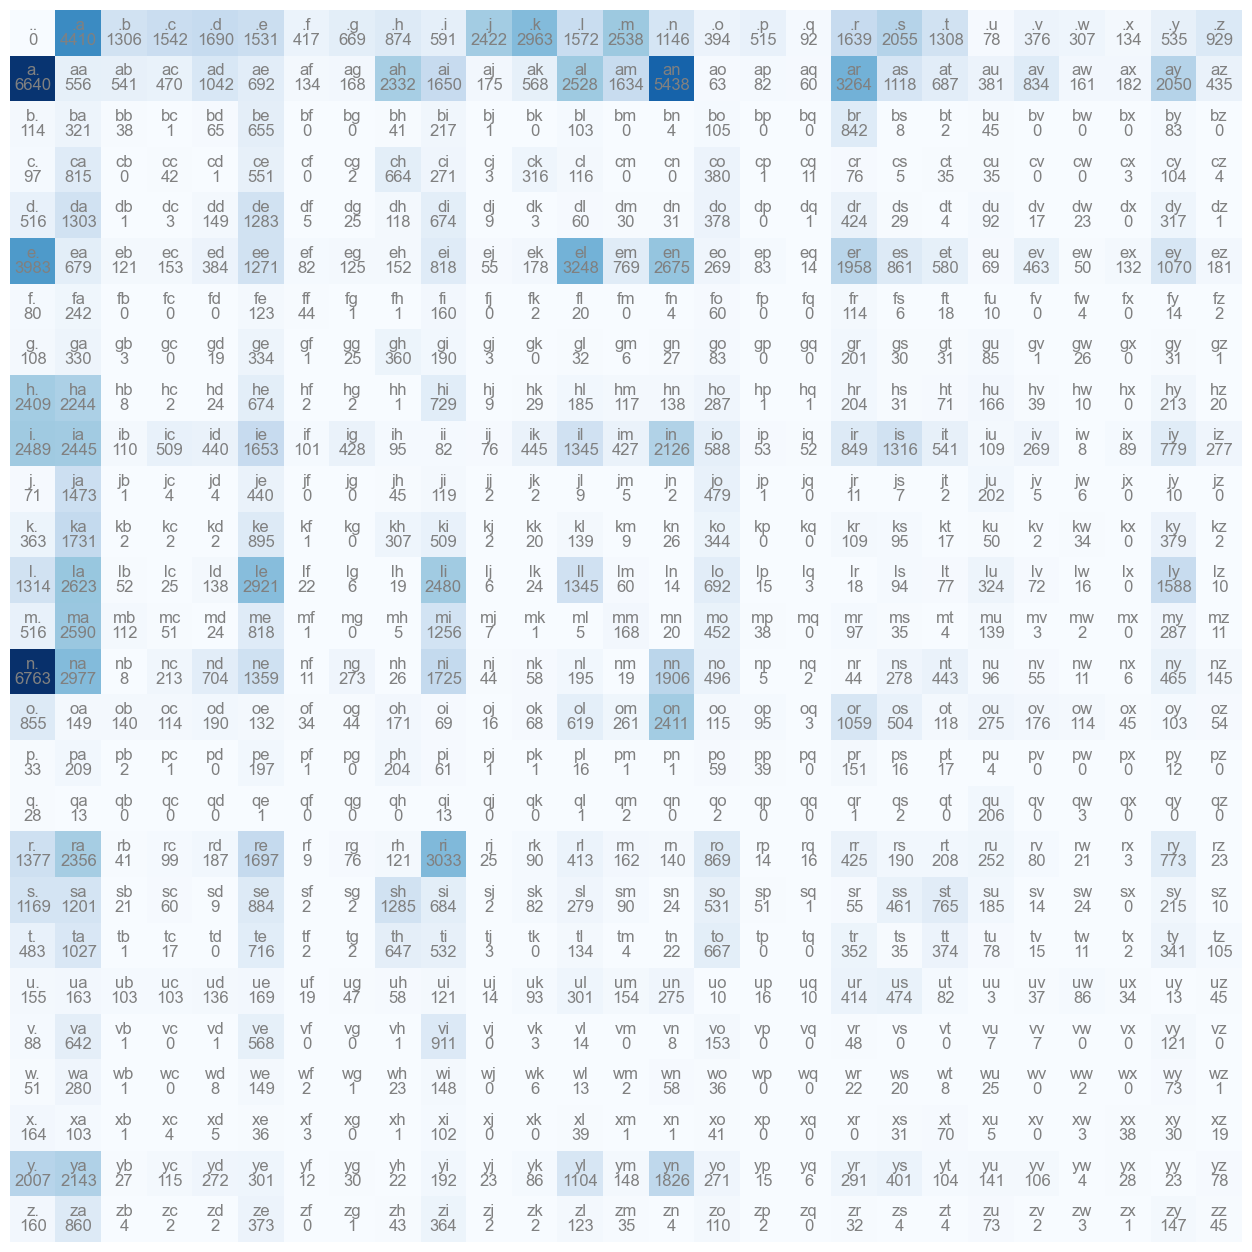

In [5]:
N = torch.zeros((CHARS, CHARS), dtype=torch.int32)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(CHARS):
    for j in range(CHARS):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

#### Sampling from the bigram matrix.

1. Assume a multinomial distribution over all rows.    
2. Start multinomial sampling from row 0 (`ix=0`) (since it represents the start of a word).    
3. Transition to the row pointed to by the sampling.    
4. Keep transitioning until we encounter row 0 (`ix=0`) again to indicate the end of the word.    

References:
1. Given probabilities, sample from categorical variables: [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html).
2. To make things deterministic, use [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html).

In [6]:
p = N[0].float()
p /= p.sum()
print(p)


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


In [7]:
# p is a valid probability distribution for torch.multinomial to sample from.
# we will eventually replace it with rows from our bigram matrix.
g = torch.Generator().manual_seed(SEED)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [8]:
torch.multinomial(p, num_samples=10, replacement=True, generator=g)


tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0])

In [9]:
g = torch.Generator().manual_seed(SEED)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'.'

**<span style="color: red;">NOTE</span>: Broadcast semantics are one of the most important project-agnostic takeaways from `makemore`**.

Make things efficient by computing normalized rows (`P`) instead of raw counts (`N`).    

Two tensors are “broadcastable” if the following rules hold:
* Each tensor has at least one dimension.
* When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must
  * either be equal,
  * one of them is 1, or 
  * one of them does not exist.

If two tensors `x`, `y` are “broadcastable”, the resulting tensor size is calculated as follows:
* If the number of dimensions of `x` and `y` are not equal, prepend 1 to the dimensions of the tensor with fewer dimensions to make them equal length.
* Then, for each dimension size, the resulting dimension size is the max of the sizes of `x` and `y` along that dimension.

References: PyTorch [Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html).

**Model Smoothing**:    
Add a small constant to all counts to avoid zero probabilities.    
NLL of unseen bigrams can result in infinite loss.    
Thus, `P=N.float()` --> `P=(N+1).float()`.

In [10]:
# 27, 27    for N.float()
# 27,  1    for N.sum(dim=1, keepdim=True)
# This is correct, because PyTorch will broadcast [27,1] to 27,27 by copying the COLUMN.
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)


# 27, 27    for N.float()
#     27    for N.sum(dim=1)
# This is incorrect, because PyTorch will broadcast [27] to [1,27] to [27,27] by copying the ROW.
# This error will pass silently and ruin us.
# Be extremely careful with broadcasting!
P_wrong = N.float()
P_wrong /= P_wrong.sum(dim=1)

In [11]:
g = torch.Generator().manual_seed(SEED)

for i in range(10):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


The above output looks like a terrible list of names for humans.    
However, bigrams are not enough to capture the structure of names.    
To understand that we did generate something reasonable, below we let go off the bigram matrix and generate names using a uniform probability distribution.

In [12]:
g = torch.Generator().manual_seed(SEED)

for i in range(10):
  
  out = []
  ix = 0
  while True:
    p = (torch.ones(CHARS)/CHARS).float()
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.
rkrrsru.
iyumuyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.


### Loss: Maximizing the likelihood of the data

`GOAL`: Maximize likelihood of the data w.r.t. model parameters (statistical modeling).    
Equivalent to maximizing the log likelihood (because log is monotonic).    
Equivalent to minimizing the negative log likelihood.    
Equivalent to minimizing the average negative log likelihood.    

`NLL` is an easy to work with transformation of the likelihood, due to
* `log` helping us sum small things up, and
* `negative` helping us minimize a positive quantity.

In [13]:
LL = 0.
N = 0

for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        LL += torch.log(P[ix1, ix2])
        N += 1

print(f"Average log-likelihood: {LL/N:.4f}")
NLL = -LL
print(f"Negative log-likelihood: {NLL/N:.4f}")

Average log-likelihood: -2.4544
Negative log-likelihood: 2.4544


Next, we replace the bigram matrix with a neural network, i.e., bigram probabilities will be generated by a nnet.

### Neural Network Bigram Model

The neural network will continue to be bigram character level model:    
$\text{char}_k  \rightarrow \text{NNet} \rightarrow \text{P(next\_char)}_{k+1}$

Evaluate the neural network parameter quality using NLL as before.    
Use gradient-based model parameter optimization.

In [14]:
# Create the training set of bigrams (x,y).
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
# torch.tensor infers dtype automatically. torch.Tensor is an alias for torch.FloatTensor.
# torch.tensor is preferred.
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [15]:
print(f"xs: {xs}")
print(f"ys: {ys}")

xs: tensor([ 0,  5, 13, 13,  1])
ys: tensor([ 5, 13, 13,  1,  0])


In [16]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=CHARS).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
W = torch.randn((CHARS, CHARS), requires_grad=True)

# [5,27] @ [27,27] --> [5,27]
pred = xenc @ W

In [18]:
# Matrix multiplication helps us do lots of dot products at once.
matrix = (xenc @ W)[3,13]
dotprod = (xenc[3] * W[:,13]).sum()
torch.isclose(matrix, dotprod).item()

True

We want the `W` matrix we learn to represent the statistics held in the bigram matrix.    
Then, `xenc` @ `W` will be equivalent to doing a dot product between the 1-hot encoding of a character    
with the corresponding row of the bigram matrix, and generating the probability distribution of the next character.

In [19]:
logits = xenc @ W   # since they can be +ve/ -ve, interpret as log-counts
counts = logits.exp()   # exponentiate to get +ves and now we can interpret as counts
probs = counts / counts.sum(dim=1, keepdim=True)    # normalize and now we can interpret as probabilities

### Summary

In [20]:
# Data we constructed before
print(f"xs: {xs}")
print(f"ys: {ys}")

xs: tensor([ 0,  5, 13, 13,  1])
ys: tensor([ 5, 13, 13,  1,  0])


In [21]:
# Randomly initialize 27 neurons, each of which receives 27 inputs.
g = torch.Generator().manual_seed(SEED)
W = torch.randn((CHARS, CHARS), generator=g)

In [22]:
# 1. One-hot encode the input characters.
# 2. Multiply by the weights to get logits.
# 3. Exponentiate to get counts.
# 4. Normalize to get probabilities.
# NOTE: 3+4 is the softmax op.
xenc = F.one_hot(xs, num_classes=CHARS).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

Without any optimization, what does the loss look like?

In [23]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'Example {i+1}: {itos[x]}{itos[y]} (idxs {x},{y})')
  print('NNet input:', x)
  #print('output probabilities from the neural net:', probs[i])
  print('Label (actual next character):', y)
  p = probs[i, y]
  print(f"Probability assigned by net to correct char:{p.item():.4f}")
  logp = torch.log(p)
  print('LL:', logp.item())
  nll = -logp
  print('NLL:', nll.item())
  nlls[i] = nll

print('=========')
print(f"Mean NLL, i.e., Loss ={nlls.mean().item():.4f}")

--------
Example 1: .e (idxs 0,5)
NNet input: 0
Label (actual next character): 5
Probability assigned by net to correct char:0.0123
LL: -4.399273872375488
NLL: 4.399273872375488
--------
Example 2: em (idxs 5,13)
NNet input: 5
Label (actual next character): 13
Probability assigned by net to correct char:0.0181
LL: -4.014570713043213
NLL: 4.014570713043213
--------
Example 3: mm (idxs 13,13)
NNet input: 13
Label (actual next character): 13
Probability assigned by net to correct char:0.0267
LL: -3.623408794403076
NLL: 3.623408794403076
--------
Example 4: ma (idxs 13,1)
NNet input: 13
Label (actual next character): 1
Probability assigned by net to correct char:0.0737
LL: -2.6080665588378906
NLL: 2.6080665588378906
--------
Example 5: a. (idxs 1,0)
NNet input: 1
Label (actual next character): 0
Probability assigned by net to correct char:0.0150
LL: -4.201204299926758
NLL: 4.201204299926758
Mean NLL, i.e., Loss =3.7693


### Now, we optimize (one step).

In [24]:
# Initialze the weights randomly.
g = torch.Generator().manual_seed(SEED)
W = torch.randn((CHARS, CHARS), generator=g, requires_grad=True)

In [25]:
# Forward pass.
xenc = F.one_hot(xs, num_classes=CHARS).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
# Compute loss.
loss = -probs[torch.arange(len(ys)), ys].log().mean()
print(loss)

tensor(3.7693, grad_fn=<NegBackward0>)


In [26]:
# Backward pass.
W.grad = None
loss.backward()

In [27]:
# Optimize.
W.data += -0.1 * W.grad

### Now, we optimize (all steps).

In [28]:
# Create dataset.
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# Initialize neuralnet.
g = torch.Generator().manual_seed(SEED)
W = torch.randn((CHARS, CHARS), generator=g, requires_grad=True)

# Initializing with the bigram matrix can help... a lot.
# W.data = P

number of examples:  228146


In [33]:
EPOCHS = 100
LR = 50
ALPHA = 0.01
#BETA = 0.001

# Gradient Descent.
for k in range(EPOCHS):
  
    # Forward.
    xenc = F.one_hot(xs, num_classes=CHARS).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() + ALPHA*(W**2).mean() #+ BETA*W.abs().mean()
    if k % 10 == 0:
        print(f"[{k}/{EPOCHS}] {loss.item():.4f}")
    
    # Backward.
    W.grad = None
    loss.backward()
    
    # Update.
    W.data += -LR * W.grad


[0/100] 2.4900
[10/100] 2.4885
[20/100] 2.4873
[30/100] 2.4863
[40/100] 2.4856
[50/100] 2.4849
[60/100] 2.4844
[70/100] 2.4839
[80/100] 2.4836
[90/100] 2.4832


The `W` we learn above is, after exponentiation, roughly equivalent to `N` (pre-normalized, i.e., not `P`).    
We explicitly computed `N` from the train data, while `W` was learnt by optimizing over the train data.    


In [37]:
g = torch.Generator().manual_seed(SEED)

for i in range(5):
  
  out1, ix1 = [], 0
  while True:
    
    # ----------
    # BEFORE:
    p1 = P[ix1]
    # ----------
    ix1 = torch.multinomial(p1, num_samples=1, replacement=True, generator=g).item()
    
    out1.append(itos[ix1])
    
    if ix1 == 0:
      break
    
  print(''.join(out1))

  
  out2, ix2 = [], 0
  while True:
    
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p2 = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    ix2 = torch.multinomial(p2, num_samples=1, replacement=True, generator=g).item()
    
    out2.append(itos[ix2])

    if ix2==0:
      break

  print(''.join(out2),"\n")

junide.
janasah. 

p.
cony. 

a.
nn. 

kohin.
tolian. 

juee.
ksahnaauranilevias. 

